# Data gathering

## Imports

In [1]:
#%matplotlib inline
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pylab as pl
from matplotlib.ticker import FormatStrFormatter

params = {'axes.labelsize': 'large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pl.rcParams.update(params)

unfiltered_data = pd.read_table('final_data_updated.csv', delimiter=',')

## Remove corrupted or invalid data

In [2]:
invalid_value_mask = np.equal(unfiltered_data, -1)
invalid_rows_mask = np.any(invalid_value_mask, axis=1)
data = unfiltered_data[~invalid_rows_mask]

## Specific projects

In [3]:
data = data.loc[data['Project'].isin(['Math', 'Time', 'Lang', 'Closure', 'Chart'])]
print(data['Project'].unique())

['Chart' 'Closure' 'Lang' 'Math' 'Time']


## Label

In [4]:
label = 'L-10'
y = data[label]

## Dataset split method

In [5]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

def createTestSet(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    scaler = MinMaxScaler()
    X_train = getScaledDataset(X_train)
    X_test = getScaledDataset(X_test)
    return (X_train, X_test, y_train, y_test)

def getScaledDataset(X):
    scaler = MinMaxScaler()
    return scaler.fit_transform(X)

# GridSearch

In [6]:
import sklearn.svm as svm
from sklearn.model_selection import GridSearchCV

#X = data.filter(regex="(S|D|T|B)-.*")
X = data[['S-ComPer', 'T-AvgVEFT', 'B-Chunks']]

X_train, X_test, y_train, y_test = createTestSet(X,y)

svc = svm.SVC(kernel='rbf')
parameters = {'gamma':np.arange(0.1,10,0.1),
              'C':np.arange(0.2,5,0.2)}

svc = GridSearchCV(svc, parameters, n_jobs=-1, cv=5)
svc.fit(X=X_train, y=y_train)

parameter = svc.best_params_
model = svc.best_estimator_

print("GridSearch training set results:")
print(svc.best_score_, parameter)
print("Score on test set:")
print(model.score(X_test, y_test))
print("Score on whole dataset:")
print(model.score(getScaledDataset(X), y))

GridSearch training set results:
0.8721804511278195 {'C': 1.6, 'gamma': 8.3}
Score on test set:
0.8955223880597015
Score on whole dataset:
0.8828828828828829


# Visualization

<IPython.core.display.Javascript object>


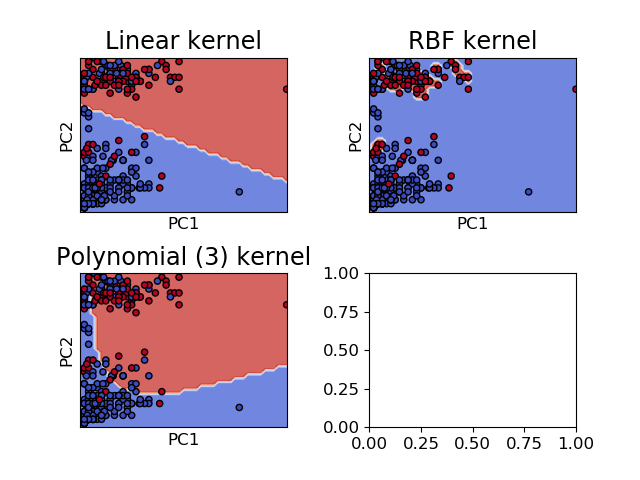

In [8]:
X = data[['D-FaultyOutD', 'D-DiDiameter']].values

def make_meshgrid(x, y, h=1):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

models = (svm.SVC(kernel='linear', **parameter),
          svm.SVC(kernel='rbf', C=0.5),
          svm.SVC(kernel='poly', **parameter, degree=3))
models = (clf.fit(X, y) for clf in models)

titles = ('Linear kernel',
          'RBF kernel',
          'Polynomial (3) kernel')


fig, sub = plt.subplots(2, 2)
plt.subplots_adjust(wspace=0.4, hspace=0.4)

X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

for clf, title, ax in zip(models, titles, sub.flatten()):
    plot_contours(ax, clf, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)